# Geolocation

#### Importing useful libraries

In [2]:
# Importing useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

/var/folders/j_/9989vv3d7z7c61s49rkzydxm0000gn/T/ipykernel_87991/2216638866.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Dataset import

In [18]:
# Replace file path with the personal one in which the dataset is contained
chunk = pd.read_csv("/Users/eliacannas/Desktop/SentimentAnalysis/venv/tweets03to06_22_sent.csv", chunksize=100000,lineterminator='\n', low_memory=False)
df = pd.concat(chunk)

## Preprocessing

#### Correcting column types

In [ ]:
# Conversion of column types
location_df = df.convert_dtypes()
location_df.dtypes
location_df.info()

#### Unknown value assignment for locations that have certain values

In [ ]:
# Replacing outliers for user_location column with Keywords 'Unknown'
location_df.loc[location_df['user_location'].str.isnumeric(), 'user_location'] = 'Unknown'
location_df.user_location = location_df.user_location.fillna('Unknown')
location_df.loc[location_df['user_location'].str.contains('#', case=False), 'user_location'] = 'Unknown'
location_df.loc[location_df['user_location'].str.contains('@', case=False), 'user_location'] = 'Unknown'
location_df.head()

In [ ]:
# Resizing the dataset by removing rows that have the value 'Unknown'
spacy_df = location_df.loc[~(location_df['user_location'] == 'Unknown')]
spacy_df.shape

#### Creating isLoc column no need to repeat step, import new dataset into next cells...

In [ ]:
# Loading pre-trained model
nlp = spacy.load("en_core_web_sm") 

In [ ]:
# This function check_for_gpe(text) accepts text as input and returns True if at least one entity detected by the spaCy model in the text is marked as GPE (Geopolitical Entity) and False otherwise.
def check_for_gpe(text):
    doc = nlp(text)
    lst = [x.label_ for x in doc.ents]
    if 'GPE'  in lst: return True
    else: return False

In [ ]:
# Addition of isLoc column containing True or False values for each user_location
spacy_df['IsLoc'] = spacy_df['user_location'].apply(lambda row: check_for_gpe(row))

#### Importing dataset with isLoc column and post import column type corrections

In [3]:
# For convenience and to avoid recalculating isLoc for each user_location let's import the table already containing this information. N.B. Replace the path with the one containing the table tweet_isLoc.csv
chunk = pd.read_csv("/Users/eliacannas/Desktop/SentimentAnalysis/venv/tweet_isLoc.csv", chunksize=100000,lineterminator='\n', low_memory=False)
spacy_df = pd.concat(chunk)
spacy_df.info()
spacy_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709584 entries, 0 to 709583
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_name        709578 non-null  object 
 1   user_location    709584 non-null  object 
 2   user_followers   709584 non-null  int64  
 3   user_friends     709584 non-null  int64  
 4   user_favourites  709584 non-null  int64  
 5   user_verified    709584 non-null  bool   
 6   date             709584 non-null  object 
 7   text             709584 non-null  object 
 8   hashtags         709579 non-null  object 
      709584 non-null  object 
 10  polarity         709584 non-null  float64
       709584 non-null  object 
 12  IsLoc            709584 non-null  bool   
dtypes: bool(2), float64(1), int64(3), object(7)
memory usage: 60.9+ MB


,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,is_retweet\r,polarity,Sentiment\r,IsLoc
0,Kotha40,"Soudersburg, PA",10357,10602,7052,False,2022-03-02,# Orijin # Polygon # IDO # BSC # Eth # BTC # A...,"['Orijin', 'Polygon', 'IDO', 'BSC', 'Eth', 'BT...",False\r,0.145833,Positive\r,True
1,Bitcoin Bot🤖,server,725,1,26,False,2022-03-02,Current # Bitcoin Price $ 44370 # BTC # Crypto,"['Bitcoin', 'BTC', 'Crypto']",False\r,0.000000,Neutral\r,False
2,Pyscho Ape,"New York, USA",1959,5002,4472,False,2022-03-02,👑Psycho Ape exclusive collection unique NFT 👑 ...,"['NFTCommunity', 'NFTGiveaway', 'art', 'NFTdro...",False\r,0.375000,Positive\r,True
3,supar fan (follow back),"Dhaka, Bangladesh",2682,3118,1516,False,2022-03-02,This project give us Good profit . I see perso...,"['Orijin', 'Polygon', 'IDO', 'BSC', 'Eth', 'BT...",False\r,0.580000,Positive\r,True
4,Christopher,Manila Mesa,28,142,341,False,2022-03-02,# btc testing testing testing 👀🚀,['btc'],False\r,0.000000,Neutral\r,True


In [4]:
# Setting dataset column types
spacy_df = spacy_df.convert_dtypes()
spacy_df.dtypes

user_name          string[python]
user_location      string[python]
user_followers              Int64
user_friends                Int64
user_favourites             Int64
user_verified             boolean
date               string[python]
text               string[python]
hashtags           string[python]
is_retweet\r       string[python]
polarity                  Float64
Sentiment\r        string[python]
IsLoc                     boolean
dtype: object

#### Reducing dataset size to valid locations (those that have value True)

In [5]:
# Resizing the dataset, removing rows where the value of isLoc is false since the user's location cannot be understood
geopy_df = spacy_df.loc[spacy_df['IsLoc']== True]
geopy_df.shape

(370766, 13)

#### Added Nation starting from the location in the dataset

In [6]:
# Method to be able to assign a nation given a location entered in the user and taken from the dataset
import geonamescache # NLP library import for nation attribution

def get_country_from_position(position): 
    gc = geonamescache.GeonamesCache()
    countries = gc.get_countries_by_names()

    # Add conditional rules to handle special cases
    if "USA" in position:
        return "United States"
    elif "UK" in position:
        return "United Kingdom"
    elif "KENYA" in position:
        return "Kenya"
    elif "Lombardia" in position:
        return "Italy"
    elif "Kingdom" in position:
        return "United Kingdom"
    elif "London" in position:
        return "United Kingdom"
    elif "England" in position:
        return "United Kingdom"
    elif "Seul" in position:
        return "South of Korea"
    elif "Burdur" in position:
        return "Turkey"
    elif "Oradea" in position:
        return "Romania"
    elif "Deutschland" in position:
        return "Deutschland"
    elif "Dubai" in position:
        return "Emirates"
    elif "NY" in position:
        return "United States"
    elif "Korea" in position:
        return "Koread"
    elif "Missouri" in position:
        return "United States"
    elif "New Delhi" in position:
        return "Emirates"
    elif "Florida" in position:
        return "United States"
    elif "California" in position:
        return "United States"
    elif "Atlanta" in position:
        return "United States"
    elif "Campania" in position:
        return "Italy"
    elif "CA" in position:
        return "United States"
    elif "Michigan" in position:
        return "United States"
    elif "colorado" in position:
        return "United States"
    elif "Paris" in position:
        return "France"
    elif "Prague" in position:
        return "Czech Republic"
    elif "ustralia" in position:
        return "Australia"
    elif "Lagos" in position:
        return "Lagos"
    elif "Montana" in position:
        return "United States"
    elif "Los Angeles" in position:
        return "United States"
    elif "BR" in position:
        return "Brazil"
    elif "MS" in position:
        return "United States"
    elif "argentina" in position:
        return "Argentina"
    elif "Hollywood" in position:
        return "United States"
    elif "Illinois" in position:
        return "United States"
    elif "indonesia" in position:
        return "Indonesia"
    elif "Ontário" in position:
        return "United States"
    elif "België" in position:
        return "Belgium"
    elif "LA" in position:
        return "United States"
    elif "Virginia" in position:
        return "United States"
    elif "Pennsylvania" in position:
        return "United States"
    elif "spain" in position:
        return "Spain"
    elif "los" in position:
        return "United States"
    elif "Alabam" in position:
        return "United States"
    elif "usa" in position:
        return "United States"
    elif "America" in position:
        return "United States"
    elif "PA" in position:
        return "United States"
    elif "NEW" in position:
        return "United States"
    elif "Ontario" in position:
        return "United States"
    elif "Oregon" in position:
        return "United States"
    elif "TX" in position:
        return "United States"
    elif "Colorado" in position:
        return "United States"
    elif "Sicilia" in position:
        return "Italy"
    elif "Sydney" in position:
        return "Australia"
    elif "FL" in position:
        return "United States"
    elif "MO" in position:
        return "United States"
    elif "IL" in position:
        return "United States"
    elif "OK" in position:
       return "United States"
    elif "UT" in position:
        return "United States"
    elif "ZA" in position:
        return "United States"
    elif "ME" in position:
        return "United States"
    elif "IA" in position:
        return "United States"
    elif "NH" in position:
        return "United States"
    elif "Madrid" in position:
        return "Spain"
    elif "ChiCaGo" in position:
        return "United States"
    elif "WA" in position:
        return "United States"
    elif "TL" in position:
        return "United States"
    elif "Danmark" in position:
        return "Denmark"
    elif "Bali" in position:
        return "Indonesia"
    elif "Cupertino" in position:
        return "United States"
    elif "U.S.A" in position:
        return "United States"
    elif "Pinang" in position:
        return "Cayman"
    elif "City" in position:
        return "United States"
    elif "Türkiye" in position:
        return "Turkey"
    elif "Lazio" in position:
        return "Italy"
    elif "Sardegna" in position:
        return "Italy"
    elif "Calabria" in position:
        return "Italy"
    elif "Piemonte" in position:
        return "Italy"
    elif "Liguria" in position:
        return "Italy"
    elif "Marche" in position:
        return "Italy"
    elif "Emilia Romagna" in position:
        return "Italy"
    elif "Trentino" in position:
        return "Italy"
    elif "Puglia" in position:
        return "Italy"
    elif "Barce" in position:
        return "Spain"
    elif "Madrid" in position:
        return "Spain"
    elif "Istanbul" in position:
        return "Turkey"
    elif "Ind" in position:
        return "India"
    elif "OH" in position:
        return "United States"
    elif "Oslo" in position:
        return "Norway"
    elif "Manila" in position:
        return "Philippines"
    elif "NV" in position:
        return "United States"
    elif "Helsinki" in position:
        return "Finland"
    elif "la" in position:
        return "United States"
    elif "ny" in position:
        return "United States"
    elif "Orange" in position:
        return "United States"
    elif "Mogadishu" in position:
        return "Somalia"
    elif "Texas" in position:
        return "United States"
    elif "CO" in position:
        return "United States"
    elif "Washington" in position:
        return "United States"
    elif "Delhi" in position:
        return "India"
    elif "beach" in position:
        return "United States"
    else: # In the case where the value is contained within the NLP library used the replacement will occur automatically
        for country_code, country_info in countries.items():
            if country_info['name'] in position:
                return country_info['name']
    return None

# Creating user_nation column and adding nation
geopy_df['user_nation'] = geopy_df['user_location'].apply(get_country_from_position)

/var/folders/j_/9989vv3d7z7c61s49rkzydxm0000gn/T/ipykernel_87991/4164134226.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geopy_df['user_nation'] = geopy_df['user_location'].apply(get_country_from_position)


#### Saving updated dataset with new column 'user_nation'

In [ ]:
# Saving the obtained dataset insided a file. 
# N.B. Replace the path with the correct path where the dataset tweet_nation.csv is contained.
geopy_df.to_csv("/Users/eliacannas/Desktop/tweet_nation.csv", index=False)

## Data Visualisation
### Graphic display of results

In [7]:
chunk = pd.read_csv("/Users/eliacannas/Desktop/SentimentAnalysis/venv/tweet_nation.csv", chunksize=100000,lineterminator='\n', low_memory=False)
geopy_df = pd.concat(chunk)
geopy_df.info()
geopy_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370766 entries, 0 to 370765
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_name        370764 non-null  object 
 1   user_location    370766 non-null  object 
 2   user_followers   370766 non-null  int64  
 3   user_friends     370766 non-null  int64  
 4   user_favourites  370766 non-null  int64  
 5   user_verified    370766 non-null  bool   
 6   date             370766 non-null  object 
 7   text             370766 non-null  object 
 8   hashtags         370763 non-null  object 
      370766 non-null  object 
 10  polarity         370766 non-null  float64
       370766 non-null  object 
 12  IsLoc            370766 non-null  bool   
 13  user_nation      326804 non-null  object 
dtypes: bool(2), float64(1), int64(3), object(8)
memory usage: 34.7+ MB


,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,is_retweet\r,polarity,Sentiment\r,IsLoc,user_nation
0,Kotha40,"Soudersburg, PA",10357,10602,7052,False,2022-03-02,# Orijin # Polygon # IDO # BSC # Eth # BTC # A...,"['Orijin', 'Polygon', 'IDO', 'BSC', 'Eth', 'BT...",False\r,0.145833,Positive\r,True,United States
1,Pyscho Ape,"New York, USA",1959,5002,4472,False,2022-03-02,👑Psycho Ape exclusive collection unique NFT 👑 ...,"['NFTCommunity', 'NFTGiveaway', 'art', 'NFTdro...",False\r,0.375000,Positive\r,True,United States
2,supar fan (follow back),"Dhaka, Bangladesh",2682,3118,1516,False,2022-03-02,This project give us Good profit . I see perso...,"['Orijin', 'Polygon', 'IDO', 'BSC', 'Eth', 'BT...",False\r,0.580000,Positive\r,True,United States
3,Christopher,Manila Mesa,28,142,341,False,2022-03-02,# btc testing testing testing 👀🚀,['btc'],False\r,0.000000,Neutral\r,True,Philippines
4,Grace,"San Francisco, California, Uni",12,4,1027,False,2022-03-02,Encryption brought us lot surprises surprises ...,"['BTC', 'ETH', 'usdtry', 'CryptoNews', 'Ada', ...",False\r,0.300000,Positive\r,True,United States


#### Graph representing through a histogram the top 20 countries of origin of tweets, we can identify that the most influential country is the United States

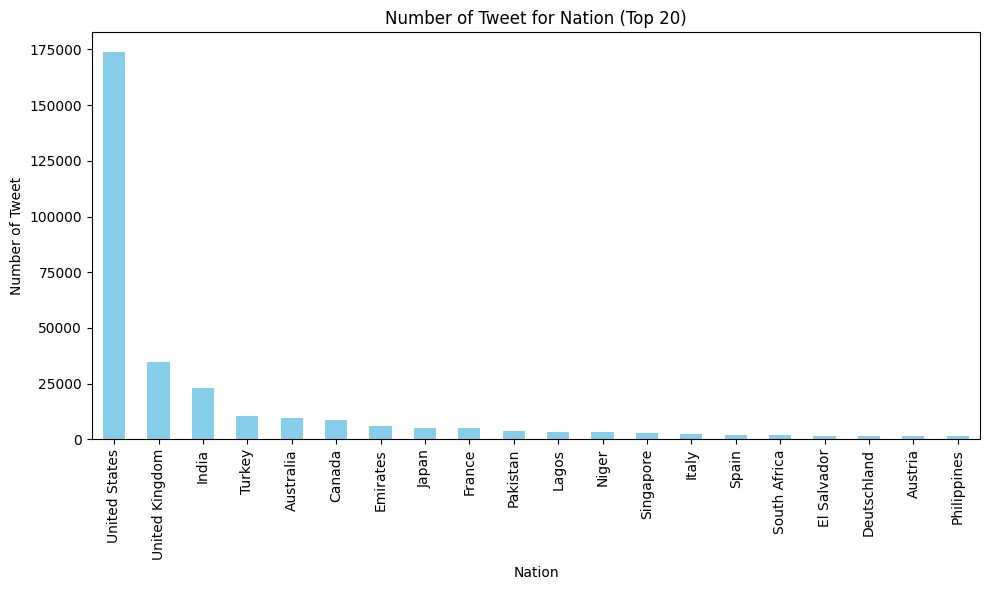

In [10]:
import matplotlib.pyplot as plt

# Count the number of tweets for each country
tweets_per_nation = geopy_df['user_nation'].value_counts().head(20)  # selects only the top 20 nations

# Create the histogram
plt.figure(figsize=(10, 6))
tweets_per_nation.plot(kind='bar', color='skyblue')

# Axis titles and labels
plt.title('Number of Tweet for Nation (Top 20)')
plt.xlabel('Nation')
plt.ylabel('Number of Tweet')

# Show histogram
plt.tight_layout()
plt.show()

#### Representation with pie chart for better evaluation of the source nations of the tweets with the percentage of the total

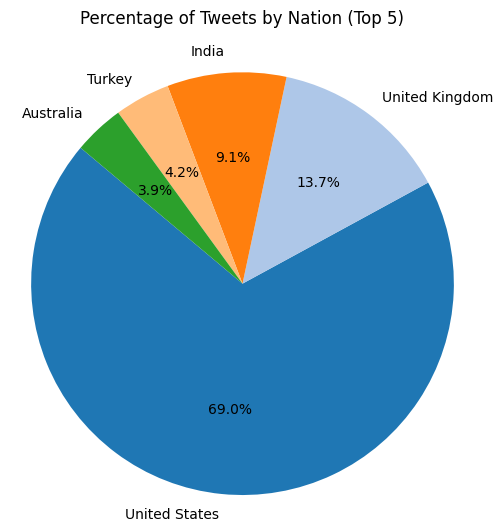

In [11]:
import matplotlib.pyplot as plt

# Count the number of tweets for each country
tweets_per_nation = geopy_df['user_nation'].value_counts().head(5)  # selects only the top 5 nations

# Calculate the percentage of tweets for each country
percentages = (tweets_per_nation / tweets_per_nation.sum()) * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Percentage of Tweets by Nation (Top 5)\n')
plt.axis('equal')  # Ensures that the pie chart is drawn as a circle
# Show graph
plt.show()